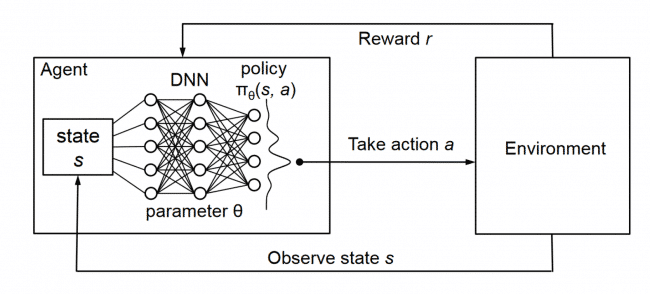

# Imports

In [10]:
import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import itertools
import random
import copy
import sys
import pygame
from IPython import display
from IPython.display import clear_output


# Plot Tool

In [11]:
plt.ion()
def plot_graphs(*graphs):
    display.clear_output(wait=True)
    # display.display(plt.gcf())   
    
    plt.clf() # Clear plot

    plt.title('DQN Agent Training process...')
    plt.xlabel('Number of Episodes')
    plt.ylabel('Values')
    
    for graph in graphs:
        plt.plot(graph)
        plt.text(len(graph)-1, graph[-1], str(round(graph[-1],2)))
    
    plt.ylim(ymin=0)    
    
    plt.show(block=False)
#     plt.pause(0.05)

# Video Engine

In [12]:
class VideoEngine:
    # Colors
    BLUE = (0, 0, 255, 1)
    YELLOW = (240, 210, 100)
    BLACK = (0, 0, 0)
    BROWN = (160, 82, 45)
    WHITE = (255, 255, 255)
    SANDSTONE= (151, 149, 124)
    SANDSONE_HOVER = (186, 181, 153)
    GREY = (200, 200, 200)
    RED = (255, 0, 0)
    GRASS_GREEN = (32, 162, 57)
    DODGER_BLUE = (30, 144, 255)
    LIGHT_GREEN = (144, 238, 144)
    CRIMSON = (220, 20, 60)
    NEON_BLUE = (122, 210, 255)

    def __init__(self, screen_size, tile_size, game_name, bg_image=None, game_tiles=None):
        # Global variables
        pygame.init()
        self.clock = pygame.time.Clock()
        self.fps = 40
        self.screen = pygame.display.set_mode((screen_size[0], screen_size[1]))
        pygame.display.set_caption(game_name)

        self.bg_image = bg_image
        if bg_image:
            self.bg_image = pygame.image.load(bg_image).convert()
            self.bg_image = pygame.transform.scale(self.bg_image, screen_size)

        self.screen_size = screen_size
        self.ts = tile_size
        self.t_in_row = int(self.screen_size[0] / self.ts)
        self.t_in_col = int(self.screen_size[1] / self.ts)
        self.tiles = game_tiles

    def render(self, grid=False, game_objects=None):
        """Draws main screen background image,tiles and grid"""
        self.clock.tick(self.fps)  # Cycles per second
        action = self.keyboard_mouse_events()

        if self.bg_image:
            self.screen.blit(self.bg_image, [0, 0])
        else:
            self.screen.fill(self.LIGHT_GREEN)

        if grid: self.draw_grid()
        if game_objects: self.draw_objects(game_objects)
        pygame.display.flip()
        return action


    def draw_objects(self, game_objects):
        for game_object in game_objects:
            for coord in game_object.body:
                if coord:
                    cell_y, cell_x = coord
                    pygame.draw.rect(self.screen, game_object.color,
                                     pygame.Rect(cell_x * self.ts, cell_y * self.ts, self.ts, self.ts))


    def draw_grid(self):
        for x in range(self.t_in_row + 1):
            for y in range(self.t_in_col + 1):
                pygame.draw.line(self.screen, self.GREY, [0, y * self.ts], [self.screen_size[0], y * self.ts])
            pygame.draw.line(self.screen, self.GREY, [x * self.ts, 0], [x * self.ts, self.screen_size[1]])


    def mouse_left_click(self, mouse_pos):
        mouse_x = mouse_pos[0] // self.ts
        mouse_y = mouse_pos[1] // self.ts
        return mouse_x, mouse_y


    def keyboard_mouse_events(self):
        """Checks keyboard/mouse actions and return Human click coordinates"""
        for event in pygame.event.get():

            if event.type == pygame.QUIT:
                pygame.display.quit()
                pygame.quit()
                sys.exit()

#             elif event.type == pygame.KEYDOWN:

#                 if event.key == pygame.K_UP:
#                     return 'UP'

#                 elif event.key == pygame.K_DOWN:
#                     return 'DOWN'

#                 elif event.key == pygame.K_LEFT:
#                     return 'LEFT'

#                 elif event.key == pygame.K_RIGHT:
#                     return 'RIGHT'


# Environment

In [13]:
class Apple:
    def __init__(self, row, col, snake_body):
        self.row = row
        self.col = col
        self.body = self.create(snake_body)
        self.color = (220, 20, 60)

    def create(self, snake_body):
        """Creates a randomly placed apple
         :return [(x,y)] coordinate"""

        while True:
            apple_body = [(random.randint(0, self.row - 1),
                      random.randint(0, self.col - 1))]            
            if apple_body[0] not in snake_body:
                break
        return apple_body


class Snake:
    def __init__(self, row, col):
        self.color = (30, 144, 255)
        
        self.row = row
        self.col = col
        
        self.body = self.create()        

        self.directions = ('NORTH', 'EAST', 'SOUTH', 'WEST')
        self.direction = 'NORTH'

    def create(self):
        """Returns an initial snake's body list: (the head in the middle, 1 peace of the body)"""
        self.direction = 'NORTH'
        self.body = [(15, 15),(16,15),(17,15)]
        return self.body

    def move(self, action):
        """ Receives LEFT RIGHT ACTION, checked"""
               
        if action == 0:
            action_id = 'FORWARD'
        elif action == 1:
            action_id = 'RIGHT'
        elif action == 2:
            action_id = 'LEFT'
        else:
            pass
        
        if action_id == 'LEFT':
            self.direction = self.directions[((self.directions.index(self.direction)) - 1) % 4]
        elif action_id == 'RIGHT':
            self.direction = self.directions[((self.directions.index(self.direction)) + 1) % 4]
        else:
            pass


        row = self.body[0][0]
        col = self.body[0][1]
        move_patterns = {'NORTH': (row - 1, col),
                         'SOUTH': (row + 1, col),
                         'WEST': (row, col - 1),
                         'EAST': (row, col + 1)}

        self.body.insert(0, move_patterns[self.direction])       
        return self.body

    def pop_tale(self):
        self.body.pop()   


class GameEnv:
    def __init__(self):
        self.row = 30
        self.col = 30

        self.boards = list(itertools.product([-1, self.row], [*range(-1, self.col + 1)])) + list(
            itertools.product([*range(-1, self.row + 1)], [-1, self.col]))
        self.snake = Snake(self.row, self.col)
        self.apple = Apple(self.row, self.col, self.snake.body)
        self.objects = [self.snake, self.apple]

        self.record_score = 0
        self.episode_score = 0
        self.steps_in_episode = 0

    def reset(self):
        '''Resets environment in the begining of each episode'''
        self.episode_score = 0
        self.steps_in_episode = 0
        self.snake.body = self.snake.create()
        self.apple.body = self.apple.create(self.snake.body)

    def get_state(self):
        """Returns 2D array (inputs,1) of state"""
        apple_row = self.apple.body[0][0]
        apple_col = self.apple.body[0][1]

        sHead_row = self.snake.body[0][0]
        sHead_col = self.snake.body[0][1]

        state = [
            # Apple location North
            sHead_row > apple_row,

            # Apple location East
            sHead_col < apple_col,

            # Apple location South
            sHead_row < apple_row,

            # Apple location West
            sHead_col > apple_col,

            # Snake Direction North
            self.snake.direction == 'NORTH',

            # Snake Direction East
            self.snake.direction == 'EAST',

            # Snake Direction South
            self.snake.direction == 'SOUTH',

            # Snake Direction West
            self.snake.direction == 'WEST',
            
            *self.close_vision(), 

        return np.array([state], dtype=float).T

    
    
    def body_on_board(self):
        snake_body = self.snake.body[2:-1]
        
        body_on_N,body_on_E,body_on_S,body_on_W = False,False,False,False
       
        for tile in snake_body:
            if tile[0] == 0: 
                body_on_N = True
            if tile[0] == self.row - 1: 
                body_on_S = True
            if tile[1] == 0: 
                body_on_W = True
            if tile[1] == self.col - 1: 
                body_on_E = True      
       
        return [body_on_N,body_on_E,body_on_S,body_on_W]
        

    def close_vision(self):
        sHead_row = self.snake.body[0][0]
        sHead_col = self.snake.body[0][1]

        N_vision = (sHead_row - 1, sHead_col)
        E_vision = (sHead_row, sHead_col + 1)
        S_vision = (sHead_row + 1, sHead_col)
        W_vision = (sHead_row, sHead_col - 1)

        close_vision_patterns = {
            'NORTH': [W_vision, N_vision, E_vision],
            'EAST':  [N_vision, E_vision, S_vision],
            'SOUTH': [E_vision, S_vision, W_vision],
            'WEST':  [S_vision, W_vision, N_vision]}

        close_vision_boolean = []

        for vision in close_vision_patterns[self.snake.direction]:
            if (vision in self.snake.body) or (vision in self.boards):
                close_vision_boolean.append(True)
            else:
                close_vision_boolean.append(False)
                
        return close_vision_boolean
    
    
    def body_distance_vision(self):
        shead_row = self.snake.body[0][0]
        shead_col = self.snake.body[0][1]

        N_vision = list(itertools.product([*range(0, shead_row)], [shead_col]))
        S_vision = list(itertools.product([*range(shead_row + 1, self.row)], [shead_col]))
        E_vision = list(itertools.product([shead_row], [*range(shead_col + 1, self.col)]))
        W_vision = list(itertools.product([shead_row], [*range(0, shead_col)]))

        NW_vision = list(zip([r for r in range(shead_row - 1, -1, -1)], [c for c in range(shead_col - 1, -1, -1)]))
        NE_vision = list(zip([r for r in range(shead_row - 1, -1, -1)], [c for c in range(shead_col + 1, self.col, +1)]))
        SW_vision = list(zip([r for r in range(shead_row + 1, self.row, +1)], [c for c in range(shead_col - 1, -1, -1)]))
        SE_vision = list(zip([r for r in range(shead_row + 1, self.row, +1)], [c for c in range(shead_col + 1, self.col, +1)]))

        eight_directions = [N_vision, NE_vision, E_vision, SE_vision, S_vision, SW_vision, W_vision, NW_vision]
       
        direction_vision_patterns = {
            'NORTH': [SW_vision ,W_vision, NW_vision, N_vision, NE_vision, E_vision, SE_vision],
            'EAST':  [NW_vision, N_vision, NE_vision, E_vision, SE_vision, S_vision, SW_vision],
            'SOUTH': [NE_vision, E_vision, SE_vision, S_vision, SW_vision, W_vision, NW_vision],
            'WEST':  [SE_vision, S_vision, SW_vision, W_vision, NW_vision, N_vision, NE_vision]}

        boolean_directions = []        
        
        for vision in direction_vision_patterns[self.snake.direction]:
            body_in_direction = set(vision).intersection(self.snake.body[2:])
            boolean_directions.append(bool(body_in_direction) * self.distance_to_nearest_body_tile(body_in_direction))
        return boolean_directions
    
    
    def coord_for_body(self):
        sHead = self.snake.body[0]
        shead_row = self.snake.body[0][0]
        shead_col = self.snake.body[0][1]

        N_vision = list(itertools.product([*range(0, shead_row)], [shead_col]))
        S_vision = list(itertools.product([*range(shead_row + 1, self.row)], [shead_col]))
        E_vision = list(itertools.product([shead_row], [*range(shead_col + 1, self.col)]))
        W_vision = list(itertools.product([shead_row], [*range(0, shead_col)]))

     
        direction_vision_patterns = {
            'NORTH': [W_vision, N_vision, E_vision,],
            'EAST':  [N_vision, E_vision, S_vision,],
            'SOUTH': [E_vision, S_vision, W_vision,],
            'WEST':  [S_vision, W_vision, N_vision,]}

        boolean_directions = [0 for i in range(3)]
 
        body_tile_index = 100_000
        vision_index = False
        
        for index,vision in enumerate(direction_vision_patterns[self.snake.direction]):
            
            body_in_direction = list(set(vision).intersection(self.boards))
            
            if bool(body_in_direction):
                for tile in body_in_direction:
                    if self.snake.body.index(tile) < body_tile_index:
                        body_tile_index = tile
                        vision_index = index
        
        if vision_index:
            boolean_directions[vision_index] = -1
            
        return boolean_directions

            
            
            
   
                                                  
    def board_distance_vision(self):
        shead_row = self.snake.body[0][0]
        shead_col = self.snake.body[0][1]

        N_vision = list(itertools.product([*range(0, shead_row)], [shead_col]))
        S_vision = list(itertools.product([*range(shead_row + 1, self.row)], [shead_col]))
        E_vision = list(itertools.product([shead_row], [*range(shead_col + 1, self.col)]))
        W_vision = list(itertools.product([shead_row], [*range(0, shead_col)]))

        NW_vision = list(zip([r for r in range(shead_row - 1, -1, -1)], [c for c in range(shead_col - 1, -1, -1)]))
        NE_vision = list(zip([r for r in range(shead_row - 1, -1, -1)], [c for c in range(shead_col + 1, self.col, +1)]))
        SW_vision = list(zip([r for r in range(shead_row + 1, self.row, +1)], [c for c in range(shead_col - 1, -1, -1)]))
        SE_vision = list(zip([r for r in range(shead_row + 1, self.row, +1)], [c for c in range(shead_col + 1, self.col, +1)]))

        eight_directions = [N_vision, NE_vision, E_vision, SE_vision, S_vision, SW_vision, W_vision, NW_vision]
       
        direction_vision_patterns = {
            'NORTH': [SW_vision ,W_vision, NW_vision, N_vision, NE_vision, E_vision, SE_vision],
            'EAST':  [NW_vision, N_vision, NE_vision, E_vision, SE_vision, S_vision, SW_vision],
            'SOUTH': [NE_vision, E_vision, SE_vision, S_vision, SW_vision, W_vision, NW_vision],
            'WEST':  [SE_vision, S_vision, SW_vision, W_vision, NW_vision, N_vision, NE_vision]}

        boolean_directions = []
        
        for vision in direction_vision_patterns[self.snake.direction]:
            body_in_direction = set(vision).intersection(self.boards)
#             boolean_directions.append(bool(body_in_direction))
            boolean_directions.append(bool(body_in_direction) * self.distance_to_nearest_body_tile(body_in_direction))
        return boolean_directions
    

    def distance_to_nearest_body_tile(self, body_in_direction):
        sHead = self.snake.body[0]
        if bool(body_in_direction):
            distance_to_nearest_body = min(np.linalg.norm(np.array(sHead)-np.array(tile)) for tile in body_in_direction)
            return 1/distance_to_nearest_body
        else:
            return 1

            
    def apple_vision(self):
        apple = self.apple.body[0]        # tuple(row,column)
        apple_row = apple[0]
        apple_col = apple[1]
        sHead = self.snake.body[0]   # tuple(row,column)
        sHead_row = sHead[0]
        sHead_col = sHead[1]
        
#         distance_to_apple = np.linalg.norm(np.array(sHead)-np.array(apple))
        
        N_vision = sHead_row > apple_row
        E_vision = sHead_col < apple_col
        S_vision = sHead_row < apple_row
        W_vision = sHead_col > apple_col
        
        apple_vision_patterns = {
            'NORTH': [W_vision, N_vision, E_vision],
            'EAST':  [N_vision, E_vision, S_vision],
            'SOUTH': [E_vision, S_vision, W_vision],
            'WEST':  [S_vision, W_vision, N_vision]}
        
        apple_vision_boolean = []

        for vision in apple_vision_patterns[self.snake.direction]:
            apple_vision_boolean.append(vision)
        
        return apple_vision_boolean

    
    def close_vision_static(self):
        sHead_row = self.snake.body[0][0]
        sHead_col = self.snake.body[0][1]

        N_vision = (sHead_row - 1, sHead_col)
        E_vision = (sHead_row, sHead_col + 1)
        S_vision = (sHead_row + 1, sHead_col)
        W_vision = (sHead_row, sHead_col - 1)

        close_vision_pattern = [N_vision, E_vision, S_vision, W_vision]

        close_vision_boolean = []

        for vision in close_vision_pattern:
            if (vision in self.snake.body) or (vision in self.boards):
                close_vision_boolean.append(True)
            else:
                close_vision_boolean.append(False)
                
        return close_vision_boolean
    
    
    def body_distance_vision_static(self):
        shead_row = self.snake.body[0][0]
        shead_col = self.snake.body[0][1]

        N_vision = list(itertools.product([*range(0, shead_row)], [shead_col]))
        S_vision = list(itertools.product([*range(shead_row + 1, self.row)], [shead_col]))
        E_vision = list(itertools.product([shead_row], [*range(shead_col + 1, self.col)]))
        W_vision = list(itertools.product([shead_row], [*range(0, shead_col)]))

        NW_vision = list(zip([r for r in range(shead_row - 1, -1, -1)], [c for c in range(shead_col - 1, -1, -1)]))
        NE_vision = list(zip([r for r in range(shead_row - 1, -1, -1)], [c for c in range(shead_col + 1, self.col, +1)]))
        SW_vision = list(zip([r for r in range(shead_row + 1, self.row, +1)], [c for c in range(shead_col - 1, -1, -1)]))
        SE_vision = list(zip([r for r in range(shead_row + 1, self.row, +1)], [c for c in range(shead_col + 1, self.col, +1)]))

        direction_vision_pattern = [N_vision, NE_vision, E_vision, SE_vision, S_vision, SW_vision, W_vision, NW_vision]

        boolean_directions = []        
        
        for vision in direction_vision_pattern:
            body_in_direction = set(vision).intersection(self.snake.body[2:])
            boolean_directions.append(bool(body_in_direction) * self.distance_to_nearest_body_tile(body_in_direction))
        return boolean_directions

    
    
    def is_apple_eaten(self):
        """Checks collision of the snake and an apple """
        return self.snake.body[0] == self.apple.body[0]

    def is_body_collision(self, snake):
        """Checks collision of the snake's head and its body """
        return self.snake.body[0] in self.snake.body[2:]

    def is_boards_collision(self, snake):
        """Checks collision of the snake and game boards """
        if snake.body[0][0] < 0 or snake.body[0][0] > self.row - 1:
            return True
        elif snake.body[0][1] < 0 or snake.body[0][1] > self.col - 1:
            return True
        else:
            return False

    def take_action(self, action):
        # a step in the environment
        state, action, reward, next_state, game_done = self.get_state(), action, None, None, None

        # Snake takes direction from (0,1,2), and makes a move
        self.snake.move(action)

        # Check is apple eaten
        if self.is_apple_eaten():
            self.apple.body = self.apple.create(self.snake.body)
            state, action, reward, next_state, game_done = state, action, 1, self.get_state(), False

            # Making apples records
            self.episode_score += 1
            self.record_score = max(self.episode_score, self.record_score)

            return state, action, reward, next_state, game_done

        self.snake.pop_tale()

        # Check collision with board
        if self.is_boards_collision(self.snake):
            state, action, reward, next_state, game_done = state, action, -1, None, True

        # Check collision with its body
        elif self.is_body_collision(self.snake):
            state, action, reward, next_state, game_done = state, action, -1, None, True

        # Prevent loop
        elif self.steps_in_episode > len(self.snake.body)*400:
            state, action, reward, next_state, game_done = state, action, 0, None, True

        # Just transit to next state
        else:

            self.steps_in_episode += 1
            state, action, reward, next_state, game_done = state, action, 0, self.get_state(), False

        return state, action, reward, next_state, game_done

# Neural Net

In [14]:
def sigmoid(x, derivative=False):
    if derivative:
        return np.multiply(x, (1 - x))
    return 1 / (1 + np.exp(-x))


def relu(x, derivative=False):
    if derivative:
        return (x > 0).astype(int)
    return np.maximum(0, x)


def linear(x, derivative=False):
    if derivative:
        return 1
    return x


def mse(target, output):
    return np.square(target - output).mean()

In [15]:
class SGD:
    def __init__(self, learning_rate):
        self.lr = learning_rate

    def proceed(self, weights, biases, gradients, gradients_b):        
        for n in range(1, len(weights)):           
            weights[n] = weights[n] - self.lr * gradients[n]
            biases[n] = biases[n] - self.lr * gradients_b[n]        
        return weights, biases
    
    
class ADAM:
    def __init__(self, learning_rate, inner_layers):
        self.lr = learning_rate
        self.ilayers = inner_layers+1
        
        # ADAM Optimizer variables
        #first moments
        self.l_w_m = [0 for i in range(self.ilayers)]
        self.l_b_m = [0 for i in range(self.ilayers)]
        #second moments
        self.l_w_v = [0 for i in range(self.ilayers)]
        self.l_b_v = [0 for i in range(self.ilayers)]

        self.t = 0
        
        
    def proceed(self, weights, biases, gradients, gradients_b):
        decay_rate_1 = 0.9
        decay_rate_2 = 0.999
        epsilon = 10**(-8)

        self.t += 1  # Increment Time Step

        # Computing 1st and 2nd moment for each layer
        for n in range(1, len(weights)):           
            self.l_w_m[n] = self.l_w_m[n] * decay_rate_1 + (1 - decay_rate_1) * gradients[n]
            self.l_b_m[n] = self.l_b_m[n] * decay_rate_1 + (1 - decay_rate_1) * gradients_b[n]
            

            self.l_w_v[n] = self.l_w_v[n] * decay_rate_2 + (1 - decay_rate_2) * np.square(gradients[n])        
            self.l_b_v[n] = self.l_b_v[n] * decay_rate_2 + (1 - decay_rate_2) * np.square(gradients_b[n])        


            # Computing bias-corrected moment
            l_w_m_corrected = self.l_w_m[n] / (1 - (decay_rate_1 ** self.t))
            l_b_m_corrected = self.l_b_m[n] / (1 - (decay_rate_1 ** self.t))

            l_w_v_corrected = self.l_w_v[n] / (1 - (decay_rate_2 ** self.t))        
            l_b_v_corrected = self.l_b_v[n] / (1 - (decay_rate_2 ** self.t))



            # Update Weights
            w_update = l_w_m_corrected / (np.sqrt(l_w_v_corrected) + epsilon)       

            b_update = l_b_m_corrected / (np.sqrt(l_b_v_corrected) + epsilon)        
     

            weights[n] -= (self.lr * w_update)        

            biases[n] -= (self.lr * b_update)        
      
        return weights, biases

In [16]:
class NeuralNet:
    def __init__(self, nodes, activations, loss, optimizer):
        self.layers = len(nodes)
        self.nodes = nodes
        self.activations = [None] + activations
        self.loss_function = loss
        self.optimizer = optimizer

        self.weights, self.biases = self.init_weights()
        

    def init_weights(self):
        weights = [None]
        biases = [None]

        for n in range(1, self.layers):
            edge = np.sqrt(1/self.nodes[n-1])

            # shape (layer, Previous Layer)
            weights.append(np.random.uniform(-edge, edge,(self.nodes[n], self.nodes[n-1])))

            # Bias shape(h,1) - only 1 Bias neuron per layer
            biases.append(np.random.uniform(-edge, edge, (self.nodes[n], 1)))
        return weights, biases
    

    def feedforward(self, input_signal):
        outputs = [input_signal]

        for i in range(1, self.layers):
            sum_product = np.dot(self.weights[i], outputs[i-1]) + self.biases[i]
            outputs.append(self.activations[i](sum_product))        
        return outputs
                           

    def predict(self, input_signal):
        prediction = self.feedforward(input_signal)[-1]
        return prediction

    
    def back_propagation(self, outputs, target):
        """The delta rule for single-layered neural networks is a gradient descent method, 
        using the derivative of the network’s weights with respect to the output error to 
        adjust the weights to better classify training examples."""
        batch_size = target.shape[1]

        weight_gradients = [None for i in range(self.layers)]
        biase_gradients = [None for i in range(self.layers)]
        deltas = [None for i in range(self.layers)]

        loss = self.loss_function(target, outputs[-1])

        # Output Layer Error and Delta
        output_error = -(2/len(target))*(target - outputs[-1])
        deltas[-1] = output_error * self.activations[-1](outputs[-1], derivative=True)

        # Hidden Layers' Errors and Deltas
        for i in range(-2, -self.layers, -1):
            error = np.dot(self.weights[i+1].T, deltas[i+1])
            deltas[i] = error * self.activations[i](outputs[i], derivative=True)
        
        # Hidden Layers' Gradients
        for i in range(-1, -self.layers, -1):
            weight_gradients[i] = np.dot(deltas[i],  outputs[i-1].T) / batch_size
            biase_gradients[i] = np.mean(deltas[i], axis=1, keepdims=True)

        return weight_gradients, biase_gradients

    
    def update_weights(self, gradients, gradients_b):
        '''Returns updated weights'''
        self.weights, self.biases = self.optimizer.proceed(self.weights, self.biases, gradients, gradients_b)

    

# DQN Agent

In [43]:
class DqnAgent:
    def __init__(self, agent_id='Snake',
                 state_inputs=11,
                 action_outputs=3,
                 gamma=0.9,
                 exploration_rate=0.5,
                 min_exploration_rate=0.001,
                 exploration_decay_steps=50000,
                 max_memory_size=200_000,
                 batch_size=512):
                
        self.state_inputs = state_inputs
        self.action_outputs = action_outputs        

        self.exploration_rate = exploration_rate
        self.min_exploration_rate = min_exploration_rate
        self.exploration_decay_rate = exploration_rate / exploration_decay_steps

        self.replay_memory = deque(maxlen=max_memory_size)        
        self.batch_size = batch_size
        self.gamma = gamma        
        
        # Neural Networks
        self.policy_net = NeuralNet(nodes=[self.state_inputs, 24, 9, self.action_outputs],
                                    activations=[relu, relu, linear],
                                    loss=mse,
                                    optimizer=ADAM(0.001,3))
        
        
        # Doube DQN settings
        self.DDQN = False
#         self.target_net = MyNeuralNet(self.state_inputs, 250, self.action_outputs)
#         self.target_net.init_weights()
#         self.update_target_net(TAU=1.0)
       


    def add_to_memory(self, experience):
        '''Adds tuple(s,a,r,ns,d) to the replay memory deque'''
        self.replay_memory.append(experience)
    
           
    def get_action(self, state):
        """ Selects an action. state = 2D array. Return integer from (0,1,2) """
        # Decay for exploration rate
        if self.exploration_rate > self.min_exploration_rate:
            self.exploration_rate -= self.exploration_decay_rate
        
        # Choose action
        if random.uniform(0, 1) > self.exploration_rate:            
            action = np.argmax(self.policy_net.predict(input_signal=state))        
        else:            
            action = random.randint(0, self.action_outputs - 1)
        return action


    def train_short_memory(self, state, action, reward, next_state, done):
        # 1: predicted Q values with current state
        prediction = self.policy_net.predict(state)
        target = np.copy(prediction)
        Q_new = reward
        
        if not done:
            if self.DDQN:
                next_action = np.argmax(self.policy_net.predict(next_state))
                Q_new = reward + self.gamma * self.target_net.predict(next_state)[next_action]
            else:
                Q_new = reward + self.gamma * np.amax(self.policy_net.predict(next_state))
        
        target[action] = Q_new
      
        feedforward = self.policy_net.feedforward(state)
        gradients = self.policy_net.back_propagation(feedforward, target, 1)
        self.policy_net.update_weights(*gradients)
        
           
    def train_long_memory(self):
        if len(self.replay_memory) > self.batch_size:
            mini_batch = random.sample(self.replay_memory, self.batch_size)
        else:
            mini_batch = self.replay_memory     
            

        # Prepare 2D arrays for batches of state inputs and target outputs
        states = np.zeros((self.state_inputs, len(mini_batch)))
        targets = np.zeros((self.action_outputs, len(mini_batch)))


        # 1. Need to create a target array with new Q value for each experience in batch        
        for index,experience in enumerate(mini_batch):
            state, action, reward, next_state, done = experience # expeirence is a tuple

            # Prediction for online net for the current state
            prediction = self.policy_net.predict(state)
            target = np.copy(prediction)
            Q_new = reward

            if not done:
                if self.DDQN:
                    next_action = np.argmax(self.policy_net.predict(next_state))
                    Q_new = reward + self.gamma * self.target_net.predict(next_state)[next_action]
                else:
                    Q_new = reward + self.gamma * np.amax(self.policy_net.predict(next_state)) 
            
            target[action] = Q_new

            states[:,index] = state[:,0]
            targets[:,index] = target[:,0]            
        

        # 2. Train our Online Net            
        feedforward = self.policy_net.feedforward(states)
        gradients = self.policy_net.back_propagation(feedforward,targets)
        self.policy_net.update_weights(*gradients)   
    
    
    def update_target_net(self, TAU=1 ,episode=0):           
        # if episode % self.update_target_net_episodes == 0:        
        self.target_net.weight_o = self.policy_net.weight_o * TAU + (1 - TAU) * self.target_net.weight_o
        self.target_net.weight_h = self.policy_net.weight_h * TAU + (1 - TAU) * self.target_net.weight_h 
        self.target_net.bias_o   = self.policy_net.bias_o   * TAU + (1 - TAU) * self.target_net.bias_o   
        self.target_net.bias_h   = self.policy_net.bias_h   * TAU + (1 - TAU) * self.target_net.bias_h  

# Main Loop

In [21]:
class AI_plays_Snake:
    def __init__(self):
        # Game objects
        self.env = GameEnv()
        self.agent = DqnAgent('snake')
        
        # Game settings
        self.row = 30
        self.col = 30
        self.max_episodes = 2000        
        self.total_score = 0
        self.record = 0
        self.mean_score_list = []
        self.score_list = []
        self.mean_500_list = []
        self.episode_score_list = []
                
        # Render Settings
        self.tile_size = 20
        self.to_render = False
        if self.to_render:
            self.display = VideoEngine((self.row * self.tile_size, self.col * self.tile_size), self.tile_size, 'Snake')
            

    def train(self):        
        for episode in range(1,self.max_episodes):
            self.env.reset()
            
            while True:
                # Render objects in each step
                if self.to_render: self.display.render(True, self.env.objects)                
                
                # get state
                state = self.env.get_state()   
                
                # Get action from the DQN Agent
                action = self.agent.get_action(state)

                # Perform action in the environment
                state, action, reward, next_state, game_done = self.env.take_action(action)

                # Train the last experience
#                 self.agent.train_short_memory(state, action, reward, next_state, game_done)
                
                
                # Add the last experience to the replay memory
                self.agent.add_to_memory((state, action, reward, next_state, game_done))
                
                if game_done:
                    

                    self.total_score += self.env.episode_score
                    self.score_list.append(self.env.episode_score)
                    
                    mean_500 = sum(self.score_list[-500:])/500#
                    self.mean_500_list.append(mean_500)#
                    
                    mean_score =  self.total_score / episode     
                    self.episode_score_list.append(self.env.episode_score)
                    self.mean_score_list.append(mean_score)                              
                    
#                     clear_output(True)
#                     print('Episode: ',episode, 'Mean score:',round(mean_score,2),'Record',self.env.record_score,'\n',flush = True)
                    if episode % 10 == 0:
                        plot_graphs(self.episode_score_list,self.mean_500_list)                                  

                    # Train agent in the end of each episode on replay memory minibatch
                    self.agent.train_long_memory()                   
                    
                    break        



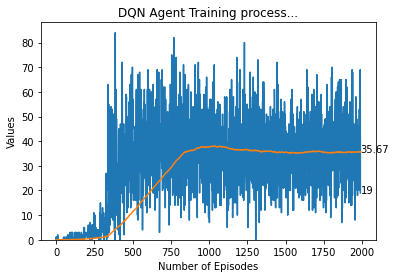

Wall time: 3min


In [31]:
%%time
game = AI_plays_Snake()
game.train()
# 11, 48, 48, 3

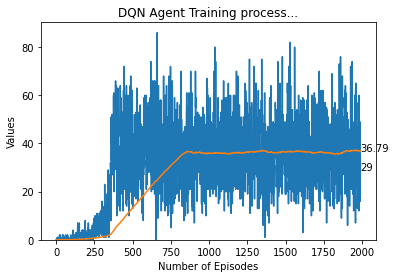

Wall time: 2min 57s


In [29]:
%%time
game = AI_plays_Snake()
game.train()
# 11, 350, 3

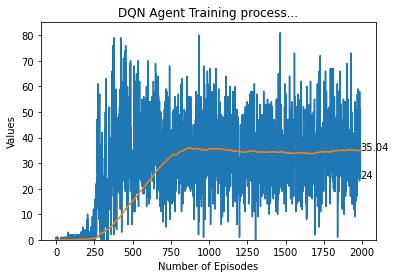

Wall time: 2min 54s


In [33]:
%%time
game = AI_plays_Snake()
game.train()
# 11, 48, 36, 3

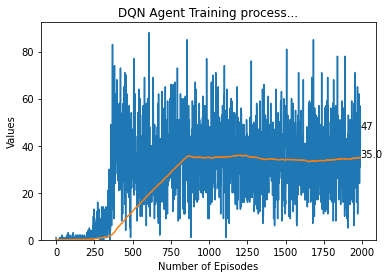

Wall time: 2min 59s


In [35]:
%%time
game = AI_plays_Snake()
game.train()
# 11, 48, 24, 3

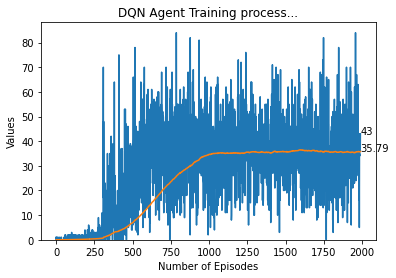

Wall time: 3min 25s


In [38]:
%%time
game = AI_plays_Snake()
game.train()
# 11, 48, 16, 3

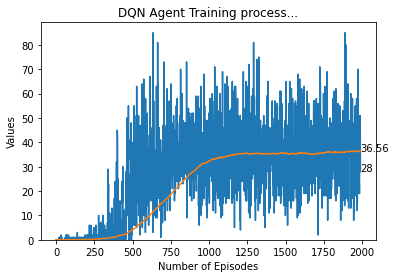

Wall time: 3min 5s


In [40]:
%%time
game = AI_plays_Snake()
game.train()
# 11, 48, 9, 3

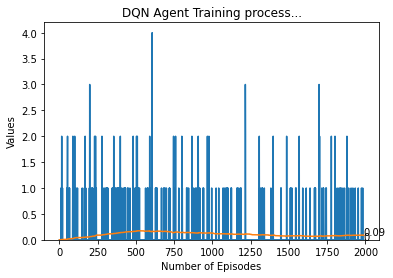

Wall time: 3min 48s


In [42]:
%%time
game = AI_plays_Snake()
game.train()
# 11, 36, 9, 3

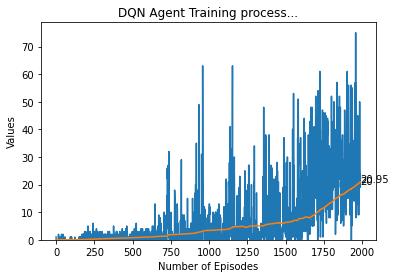

Wall time: 3min 55s


In [44]:
%%time
game = AI_plays_Snake()
game.train()
# 11, 24, 9, 3